# EDX Spectra Quantification

Quantification of the atomic fractions of elements in a material from EDX spectra is a problem which is addressed in many commercial software packages – such as Velox – however these software packages typically take a "black box" approach to quantification, treating the algorithms involved as proprietary. This notebook "opens up" the black box, giving full transparency and control to the researcher. This allows for greater understanding of how the quantification is actually performed, more control over techniques and coefficients, and the ability to modify the process to suit the needs of particular research problems.

## File IO

We'll handle file IO with the `hyperspy` library. Another good option would be `RosettaSciIO`, which grew out of `hyperspy` and so has support for many different types of electron microscopy file formats (such as `.mrc` and `.dm4`), as well as scientific file formats for other kinds of data and more generic file types (such as `.tiff`). The two libraries will format the metadata slightly differently (I actually find the `RosettaSciIO` metadata format to be a bit more pythonic, although opinions will differ) but they are broadly similar in terms of functionality, and using `hyperspy` saves us an import and some initial setup since we'll be using it (and an extension called `exspy`) for analysis.

The `hyperspy` documentation can be found here: [https://hyperspy.org/hyperspy-doc/current/](https://hyperspy.org/hyperspy-doc/current/); this notebook is largely following along with the [`hyperspy` EDS tutorial](https://hyperspy.org/hyperspy-doc/v1.1/user_guide/eds.html).

The `exspy` documentation can be found here: [https://exspy.readthedocs.io/en/latest/index.html](https://exspy.readthedocs.io/en/latest/index.html)

The `RosettaSciIO` documentation can be found here, should you choose to use it: [https://hyperspy.org/rosettasciio/index.html](https://hyperspy.org/rosettasciio/index.html).

In [1]:
import hyperspy.api as hs
import exspy as hsx
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In the first line of the below cell you can optionally set a file name. This should either be a literal string, e.g. `r"C:\path\to\file.emd"` or `"/path/to/file.emd"`, or a `pathlib` Path object (see the `pathlib` documentation [here](https://docs.python.org/3/library/pathlib.html)).

You can also leave the filename set to `None`, which will spawn an interactive file picker window using your operating system's native interface.

In [2]:
fname: str | Path | None = None  # Set filename, or set to None for interactive file selection

if fname is not None:
    infile = hs.load(fname, select_type="single_spectrum")
else:
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    root = Tk()
    root.iconify()
    root.attributes('-topmost', True)
    root.update()
    try:
        infile = hs.load(askopenfilename(parent=root), select_type="single_spectrum")
    finally:
        root.attributes('-topmost', False)
        root.destroy()

### File Structure
If the file you opened represents data captured on our Themis, you'll find that `infile` contains a list of four elements. Each element of this list represents one of the four segments of the SuperX detector on the Themis, and is an `EDSTEMSpectrum` object that contains a variety of data and metadata:

+ `data` is the raw spectral data
+ `metadata` contains some of the important metadata, such as accelerating voltage and stage position, as well as some file-related metadata like the original file name and the date and time that the file was created
+ `original_metadata` contains all of the technical metadata that was saved by the microscope software, including (in the case of `.emd` files) things like vacuum status, spot size, lens intensities, and so on; we will need to access some of this (such as the dispersion), but we'll do it programatically since directly searching the huge metadata tree is tedious
+ `axes_manager` can be used to adjust the axes of the data – in this case, since we have loaded only the spectral data, there will be only one axis per segment
+ `isig` is used to index into a signal axis (in this case, the only signal axis we have is "Energy"), and also supports floating-point indexing in the units of the signal axis
+ The `EDSTEMSpectrum` objects also have a variety of other attributes (such as`inav` and `events`) which we don't need to concern ourselves with for now

We can have a look at our data and metadata using the following cell, although depending on your IDE (e.g. Spyder, PyCharm, JupyterLab, etc) you might have more convenient ways of inspecting this data structure:

In [3]:
# The data is different between the four segments, but the metadata should be the same
print("RAW DATA:")
for i in range(4):
    print(f"Segment {i+1}: {infile[i].data}")
print("\nMETADATA:")
print(infile[0].metadata)
# Uncomment below if you want to see all of the metadata; it will print _a lot_ of text
# print("ORIGINAL_METADATA:")
# print(infile[0].original_metadata)

RAW DATA:
Segment 1: [  0   0   0 ... 195 168 203]
Segment 2: [  1  12   4 ... 198 186 178]
Segment 3: [  1   1   1 ... 181 176 184]
Segment 4: [  1   1   0 ... 176 186 172]

METADATA:
├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       ├── Stage
│       │   ├── tilt_alpha = 0.006
│       │   ├── tilt_beta = 0.002
│       │   ├── x = -0.000118
│       │   ├── y = -4.1e-05
│       │   └── z = -1.5e-05
│       ├── beam_energy = 200.0
│       ├── camera_length = 65.0
│       ├── magnification = 114999.99999999999
│       └── microscope = Titan
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 2.2.0
│   │       ├── io_plugin = rsciio.emd
│   │       ├── operation = load
│   │       └── timestamp = 2025-06-17T14:50:16.732357-04:00
│   ├── date = 2025-02-14
│   ├── original_filename = Au-10Pt-500C S

### EDX Data

Now that we know how things are formatted, let's take a look at the actual spectral data, first summing all of the individual detectors. Doing the summation as below will return another `EDSTEMSpectrum` object with properly calibrated axes.

Note that you can skip this step if you supply the keyword parameter `sum_EDS_detectors=True` when you load the file, which will automatically perform the summation at load-time:

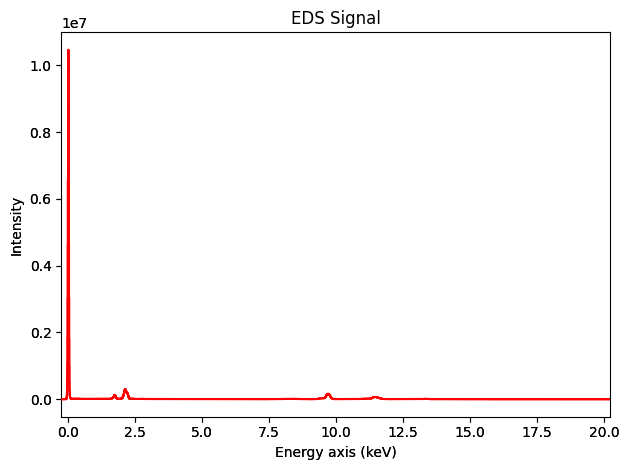

In [4]:
total_spectrum = infile[0] + infile[1] + infile[2] + infile[3]
total_spectrum.plot()

The most obvious feature of this spectrum is the enormous peak at zero: this is variously known as the "strobe peak", "noise peak", or "zero-energy peak", and results from electrical noise in the detector. It's very useful for calibration -- it is how Velox found the zero point of this sepctrum in the first place -- but it obscures our visualization, so let's plot only energies above 200 eV.

We can use the `isig` attribute to slice the energy axis with numpy-like syntax. If we slice `isig` with a floating point value, it will automatically slice based on the units of the erergy axis. Note that integers will still slice by index, so if you want to see energies above 1 keV you must slice `total_signal[1.:]` and not `total_signal[1:]`.

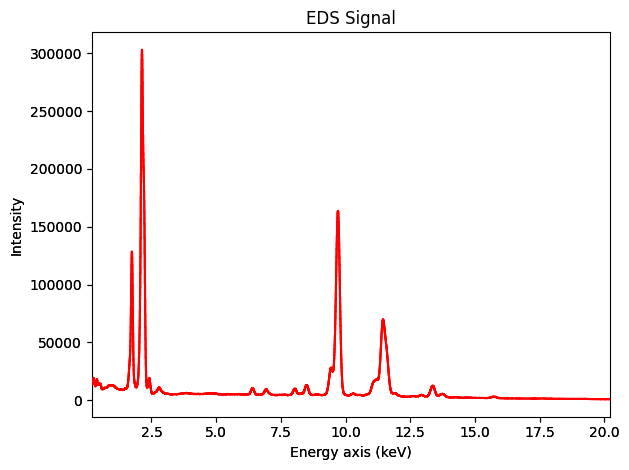

In [5]:
total_spectrum.isig[0.2:].plot()

## Peak Identification

Now that we can see our spectrum, we'd like to identify what peaks we're looking at. First we can check and see which elements were marked when this file was saved from Velox, and then we can add some additional elements that we suspect may be present in this dataset:

In [6]:
print(total_spectrum.metadata.Sample.elements)

# Add elements
total_spectrum.add_elements(["Si", "N", "Cu", "Fe"])
print(total_spectrum.metadata.Sample.elements)

['Pt', 'Au']
['Au', 'Cu', 'Fe', 'N', 'Pt', 'Si']


We can also have `hyperspy` auto-identify the most intense lines per element, and if we'd like additional lines we can add them manually:

['Au_La', 'Au_Lb1', 'Au_Lb4', 'Au_Ll', 'Au_M2N4', 'Au_M3O4', 'Au_M3O5', 'Au_Ma', 'Au_Mb', 'Au_Mg', 'Au_Mz', 'C_Ka', 'Cu_Ka', 'Cu_Kb', 'Cu_La', 'Cu_Lb1', 'Cu_Lb3', 'Cu_Ll', 'Cu_Ln', 'Fe_Ka', 'Fe_Kb', 'Fe_La', 'Fe_Lb3', 'Fe_Ll', 'Fe_Ln', 'N_Ka', 'O_Ka', 'Pt_La', 'Pt_Lb1', 'Pt_Lb2', 'Pt_Lb3', 'Pt_Ma', 'Pt_Mb', 'Pt_Mg', 'Si_Ka', 'Si_Kb']


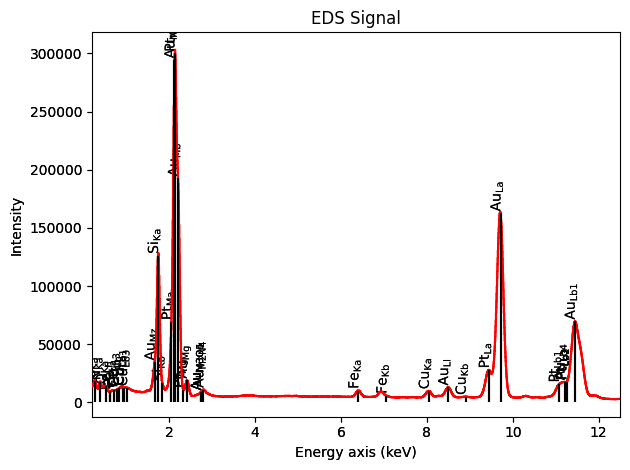

In [39]:
# Auto-identifies the most intense lines in the energy range
total_spectrum.add_lines()

# You can also specify lines manually:
total_spectrum.add_lines(["Au_La", "Au_Ma", "Au_Mb",
                          "Pt_La", "Pt_Ma", "Pt_Mb",
                          "Si_Ka", "Si_Kb",
                          "Cu_Ka", "Cu_Kb", "Cu_La",
                          "Fe_Ka", "Fe_Kb", "Fe_La"])
print(total_spectrum.metadata.Sample.xray_lines)

# Passing True as the first positional parameter to `plot()` will add the lines to the plot
# We'll plot up to just 10 keV to avoid crowding the plot too much with all these lines
total_spectrum.isig[0.2:12.5].plot(True)

We can also identify unknown peaks based on `hyperspy`'s built-in database of line energies. For example, there are a couple of peaks near 2.4 keV which don't belong to any of the peaks we added manually, as well as one betweeh the two Cu K lines. Let's try to identify these.

First we need to locate our peaks: `hyperspy` can do this using the [O'Haver algorithm](https://terpconnect.umd.edu/~toh/spectrum/PeakFindingandMeasurement.htm) (function documentation [here](https://hyperspy.org/hyperspy-doc/current/reference/api.signals/Signal1D.html#hyperspy.api.signals.Signal1D.find_peaks1D_ohaver)):

C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\hyperspy\_signals\signal1d.py:150: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  d = np.gradient(medfilt(y, medfilt_radius))


[########################################] | 100% Completed | 103.32 ms


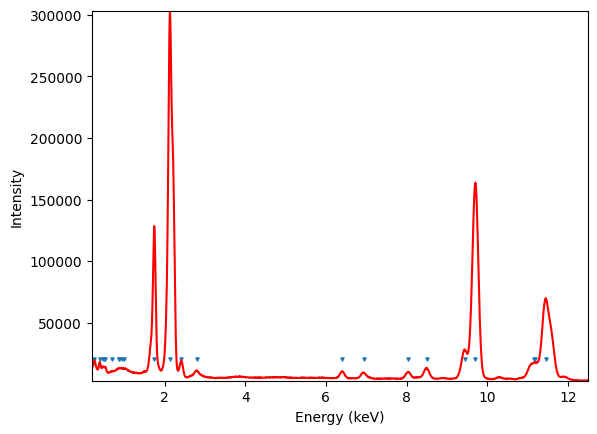

In [8]:
# We need to reduce the peak amplitude (in units of counts) to find the small peaks
# We might also need to turn up the slope threshold to suppress broad peaks
# The median filtering radius can be adjusted to suppress noise
# These parameters will need to be fine-tuned per spectrum
peaks = total_spectrum.isig[0.2:12.5].find_peaks1D_ohaver(amp_thresh=9400,
                                                         slope_thresh=0,
                                                         medfilt_radius=11)[0]

# Plotting to help visualize which peaks we've found
ax = hs.plot.plot_spectra(total_spectrum.isig[0.2:12.5], color="red")
ax.scatter([p["position"] for p in peaks], [20000]*peaks.size, marker="v", s=5)
plt.show()

Now that we know where the peaks are, we can have auto-identify them based on the peak database maintained by `hyperspy`:

In [9]:
lines = []
for p in peaks:
    lines.extend(hsx.utils.eds.get_xray_lines_near_energy(p["position"],
                                                          width=0.2))  # Adjust search width as needed
lines = set(lines)  # Cast to set to remove duplicates
print(lines)

{'Pm_Mb', 'Tb_Lg3', 'Eu_Mz', 'Yb_Lg1', 'Lu_M2N4', 'Re_M2N4', 'Hf_Lb2', 'Ru_Ln', 'Hg_Ma', 'Mn_La', 'Sc_La', 'Rb_Lb1', 'Sm_Ma', 'Ta_M3O4', 'Kr_Lb3', 'Au_M2N4', 'Mn_Kb', 'Ni_La', 'Bi_Ma', 'Pb_Ma', 'Ta_Ma', 'Er_Lg3', 'Fe_Ll', 'F_Ka', 'Tm_Mg', 'Cu_Ka', 'At_La', 'Au_Ll', 'Nb_Lb2', 'Zr_Ll', 'Ce_Mg', 'Nd_Mz', 'Au_Mz', 'Hg_Mz', 'Ca_Ln', 'Pd_Ll', 'Ni_Lb1', 'Dy_La', 'Ir_Ll', 'Tl_Mb', 'Cu_La', 'Sc_Ll', 'Tm_Lb4', 'Co_La', 'Mo_Lb1', 'Rh_La', 'La_Mz', 'Er_M2N4', 'Bi_Mg', 'Po_La', 'Nb_Lg1', 'V_La', 'Rn_Mb', 'Ni_Lb3', 'Ce_Ma', 'Au_Lb1', 'Cl_Kb', 'Os_M2N4', 'Nb_La', 'Tm_Lg1', 'Ni_Ll', 'S_Kb', 'Cd_Ll', 'Fr_Mb', 'Pm_Ma', 'Tm_Lg3', 'Cr_Ll', 'Er_Mz', 'Na_Kb', 'Rn_Mz', 'V_Ln', 'Au_Mg', 'Dy_Lg1', 'Mo_Lg3', 'Rb_La', 'Ce_Mz', 'Hg_M3O5', 'Lu_Mg', 'Ir_Ln', 'Pt_Mb', 'At_Mb', 'Ge_Ll', 'Yb_Lb1', 'Ta_Lb3', 'Er_La', 'Mn_Ln', 'Au_M3O4', 'Ta_Ln', 'Tb_Lg1', 'Tc_Lg1', 'Re_M3O5', 'Ra_Mz', 'U_Mz', 'Yb_Lb3', 'Ta_M2N4', 'Y_Lg1', 'C_Ka', 'Cr_Ln', 'W_Mg', 'O_Ka', 'Cu_Lb1', 'Pb_Mz', 'Eu_Lb4', 'Tm_Ll', 'Ti_Lb3', 'Cu_Lb3', 'Ta_Mb'

The set of lines we found probably includes a lot of lines from elements which are unlikely to actually be present in the sample (depending on what file you loaded to work on), so we can filter it down by elements we expect to plausibly be in the sample:

In [10]:
expected_elements = {"Au", "Pt", "Si", "N", "Cu", "Fe", "C", "O"}

marked_for_removal = set()
for line in lines:
    keep = False
    for e in expected_elements:
        if e+"_" in line:  # Underscore needed to avoid matching, e.g., potassium w/ all K lines or C w/ Co
            keep = True
            break
    if keep is True:
        continue
    marked_for_removal.add(line)
lines = lines - marked_for_removal
print(lines)

{'Au_Ma', 'Fe_Lb3', 'Si_Kb', 'Au_Mg', 'Au_M2N4', 'Pt_Mg', 'Pt_Mb', 'Pt_Lb2', 'Fe_Ll', 'Cu_Ka', 'Au_M3O4', 'Au_Ll', 'Pt_Ma', 'Au_Mz', 'C_Ka', 'Si_Ka', 'Au_Mb', 'O_Ka', 'Cu_Lb1', 'Pt_Lb3', 'Cu_Lb3', 'Au_Lb4', 'Cu_La', 'Cu_Ln', 'Fe_Ka', 'Fe_La', 'Cu_Ll', 'Pt_La', 'N_Ka', 'Au_M3O5', 'Fe_Ln', 'Pt_Lb1', 'Au_Lb1', 'Au_La'}


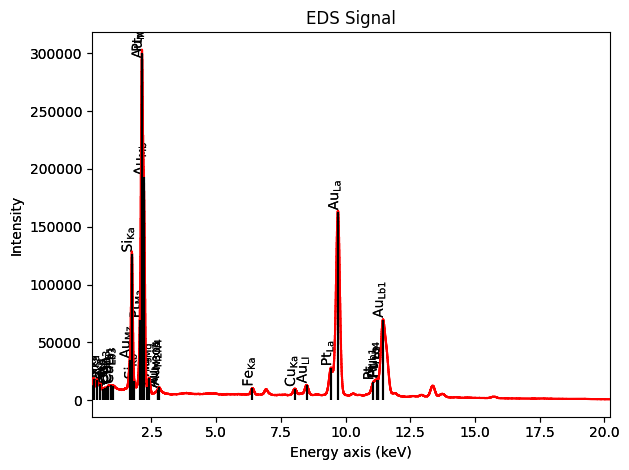

In [38]:
total_spectrum.metadata.Sample.xray_lines = []  # Reset to remove the lines we added manually before
# Note that adding lines automatically adds any new elements to metadata.Sample.elements
total_spectrum.add_lines(list(lines))
total_spectrum.isig[0.2:12.5].plot(True)

# Quantification

Now that we've identified the peaks in our spectrum (at least, all of the important peaks), we can work on quantifying the composition of the sample.

The first step is to fit the spectrum, which will allow us to get proper, background-subtracted intensities for each peak. `hyperspy` offers a significant amount of automation surrounding spectrum fitting and quantification. It is possible to dig in and manually perform each of the steps if so desired, but here we'll stick with the automated approach, which is very quick to implement. Refer to the `hyperspy` and `exspy` documentation for more information if you so desire, though:

C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\exspy\models\edsmodel.py:708: UserWarning: The X-ray line expected to be in the model was not found
  warnings.warn(


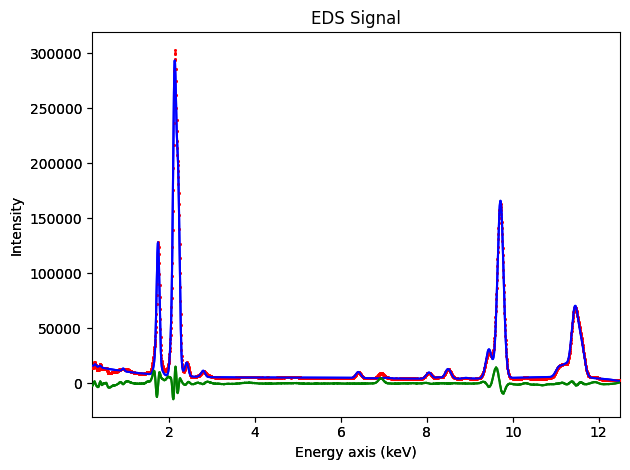

In [12]:
spectrum_model = total_spectrum.isig[0.2:12.5].create_model()
spectrum_model.fit_background()
spectrum_model.multifit()

# We can also further refine particular peaks which are of interest to us
refine_elements = {"Au", "Pt"}
cal_lines = [line for line in total_spectrum.metadata.Sample.xray_lines
             for e in refine_elements if e+"_" in line]
spectrum_model.calibrate_xray_lines(calibrate="energy", xray_lines=cal_lines, kind="multi")
spectrum_model.calibrate_xray_lines(calibrate="sub_weight", xray_lines=cal_lines, kind="multi")
spectrum_model.calibrate_xray_lines(calibrate="width", xray_lines=cal_lines, kind="multi")

# spectrum_model.print_current_values()  # Uncomment to see all fitting parameters (there are a lot)
spectrum_model.plot(plot_residual=True)

Now that we have an optimized spectrum fit, we can get the integrated peak intensities for each line we've identified in the spectrum:

In [13]:
# Select just the lines you're going to be further quantifying, else hyperspy will complain in the next step
intensities = spectrum_model.get_lines_intensity(xray_lines=["Au_La", "Pt_La", "Au_Ma", "Pt_Ma"],
                                                 plot_result=True)

Au_La at 9.713 keV : Intensity = 5659882.34
Pt_La at 9.4421 keV : Intensity = 910029.91
Au_Ma at 2.1229 keV : Intensity = 4358686.50
Pt_Ma at 2.0505 keV : Intensity = 506908.36


There are several different ways to quantify the composition of the sample based on these intensities, which are described in the `hyperspy` documentation. These are: Cliff-Lorimer $k$ factors (unitless), $\zeta$ factors (mg/m^2), or ionization cross-sections (barns).

In all cases, the best thing to do is to measure the factors directly in the microscope used for the experiment, using a standard sample of known composition and the same parameters as were used in the experiment at hand. Another approach is to look up some parameters in the literature and hope their ratio is not too different from what it is in your experimental data. Again, this is not advised if you can get a good standard sample, but for many materials systems such standards may not exist.

Here I'm going to use the $k$ factors presented in [Schreiber and Wims, 1981](https://www.sciencedirect.com/science/article/pii/S0304399181802343) to quantify the composition of the sample. I'll do the quantificaiton twice, once using L lines and once using M lines, to see how much the choice of line pair affects our answer.

Note: $k$ factors are always given referenced to some other element (Si in the case of Schreiber and Wims), and obey the relations:
$$
k_{AB} \frac{I_A}{I_B} = \frac{C_A}{C_B}
$$
and
$$
k_{AB} = k_{AC}k_{CB} = \frac{k_{AC}}{k_{BC}}
$$

This second relationship is what allows us to use the Si-referenced $k$ factors from Schreiber and Wims directly in the code below.

In [14]:
# k factors must be ordered the same order as the above intensities
k_factors_Ma = [1.90, 1.88]
M_quant = total_spectrum.quantification(intensities[2:], method='CL', factors=k_factors_Ma)
print("From Ma lines:\n"
      f"Au: {M_quant[0].data[0]/100:.1%}\n"
      f"Pt: {M_quant[1].data[0]/100:.1%}\n")

k_factors_La = [4.07, 3.99]
L_quant = total_spectrum.quantification(intensities[:2], method='CL', factors=k_factors_La)
print("From La lines:\n"
      f"Au: {L_quant[0].data[0]/100:.1%}\n"
      f"Pt: {L_quant[1].data[0]/100:.1%}\n")

[########################################] | 100% Completed | 104.39 ms
From Ma lines:
Au: 89.6%
Pt: 10.4%
[########################################] | 100% Completed | 104.16 ms
From La lines:
Au: 86.3%
Pt: 13.7%


### Quantifying specific energy ranges

We can attempt to slightly improve our fits – and, thus, our quantification – by making models that represent just the energy ranges where our elements of interest have prominent lines. Let's start by having a closer look at the current fits in the energy ranges of interest, so we have a point of comparison. **Note:** It's going to be important to widen our energy range a bit so that we have some background we can fit.

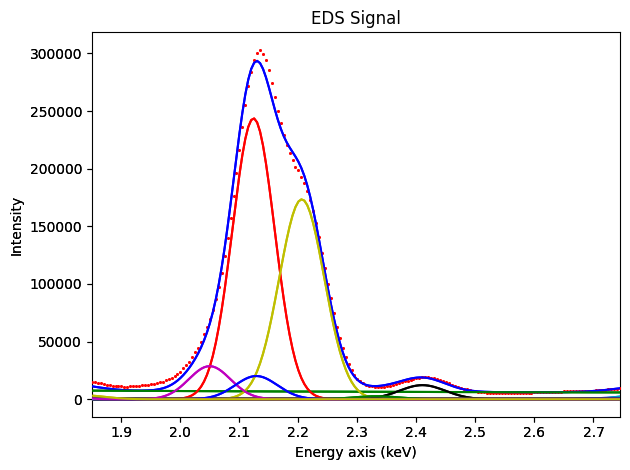

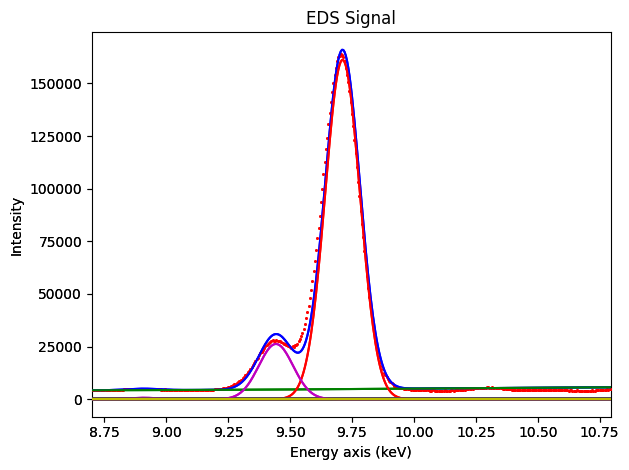

In [15]:
spectrum_model.isig[1.85:2.75].plot(plot_components=True)
spectrum_model.isig[8.7:10.8].plot(plot_components=True)

In [16]:
m_spectrum = total_spectrum.deepcopy()
m_spectrum.crop("Energy", start=1.85, end=2.75)

l_spectrum = total_spectrum.deepcopy()
l_spectrum.crop("Energy", start=8.7, end=10.8)

[########################################] | 100% Completed | 106.50 ms


C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\hyperspy\_signals\signal1d.py:150: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  d = np.gradient(medfilt(y, medfilt_radius))


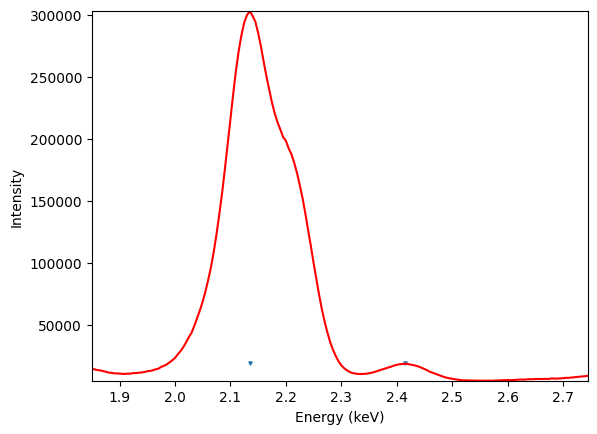

{'Pt_Mg', 'Au_Ma', 'Pt_Mb', 'Au_Mb', 'Au_Mg', 'Pt_Ma'}


In [17]:
m_peaks = m_spectrum.find_peaks1D_ohaver(amp_thresh=10000,
                                         slope_thresh=200)[0]

ax = hs.plot.plot_spectra(m_spectrum, color="red")
ax.scatter([p["position"] for p in m_peaks], [20000]*m_peaks.size, marker="v", s=5)
plt.show()

m_lines = []
for p in m_peaks:
    m_lines.extend(hsx.utils.eds.get_xray_lines_near_energy(p["position"],
                                                            width=0.2))  # Adjust search width as needed
m_lines = set(m_lines)
m_expected_elements = {"Au", "Pt"}

m_marked_for_removal = set()
for line in m_lines:
    keep = False
    for e in m_expected_elements:
        if e+"_" in line:
            keep = True
            break
    if keep is True:
        continue
    m_marked_for_removal.add(line)
m_lines = m_lines - m_marked_for_removal
print(m_lines)

[########################################] | 100% Completed | 103.73 ms


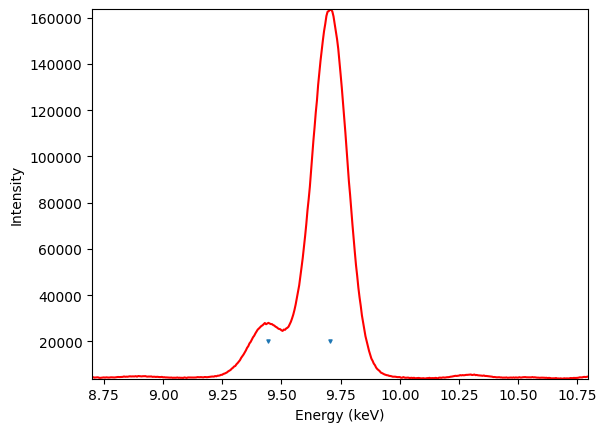

{'Au_La', 'Pt_La'}


In [18]:
l_peaks = l_spectrum.find_peaks1D_ohaver()[0]

ax = hs.plot.plot_spectra(l_spectrum, color="red")
ax.scatter([p["position"] for p in l_peaks], [20000]*l_peaks.size, marker="v", s=5)
plt.show()

l_lines = []
for p in l_peaks:
    l_lines.extend(hsx.utils.eds.get_xray_lines_near_energy(p["position"],
                                                            width=0.2))  # Adjust search width as needed
l_lines = set(l_lines)
l_expected_elements = {"Au", "Pt"}

l_marked_for_removal = set()
for line in l_lines:
    keep = False
    for e in l_expected_elements:
        if e+"_" in line:
            keep = True
            break
    if keep is True:
        continue
    l_marked_for_removal.add(line)
l_lines = l_lines - l_marked_for_removal
print(l_lines)

C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\exspy\models\edsmodel.py:708: UserWarning: The X-ray line expected to be in the model was not found
  warnings.warn(


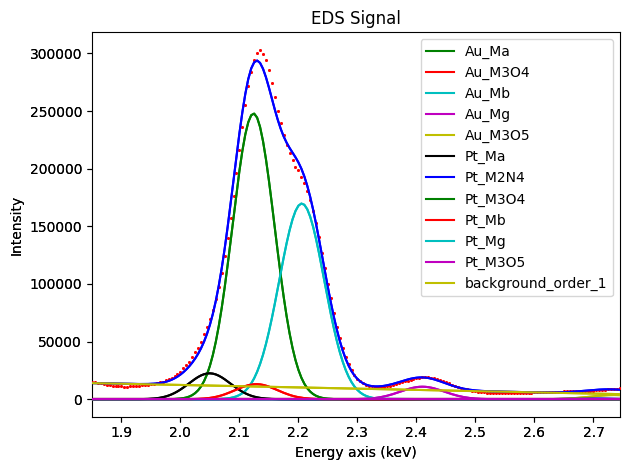

[########################################] | 100% Completed | 103.59 ms
From Ma lines (local fitting):
Au: 91.8%
Pt: 8.2%


In [19]:
m_model = m_spectrum.create_model(auto_background=False)
m_model.add_polynomial_background(order=1)
m_model.multifit()

# We can also further refine particular peaks which are of interest to us
m_refine_elements = {"Au", "Pt"}
m_cal_lines = [line for line in m_spectrum.metadata.Sample.xray_lines
               for e in m_refine_elements if e+"_" in line]
m_model.calibrate_xray_lines(calibrate="energy", xray_lines=m_cal_lines, kind="multi")
m_model.calibrate_xray_lines(calibrate="sub_weight", xray_lines=m_cal_lines, kind="multi")
m_model.calibrate_xray_lines(calibrate="width", xray_lines=m_cal_lines, kind="multi")

# spectrum_model.print_current_values()  # Uncomment to see all fitting parameters (there are a lot)
m_model.plot(plot_components=True)
names = [comp.name for comp in m_model.active_components]
colors = [line.get_color() for line in plt.gca().get_lines()[-len(names):]]
handles = [Line2D([0], [0], color=c, label=n) for n, c in zip(names, colors)]
plt.gca().legend(handles=handles, loc="best")
plt.show()

m_intensities = m_model.get_lines_intensity(xray_lines=["Au_Ma", "Pt_Ma"])
# Following line references the k factors set previously
M_quant_local = m_spectrum.quantification(m_intensities, method='CL', factors=k_factors_Ma)
print("From Ma lines (local fitting):\n"
      f"Au: {M_quant_local[0].data[0]/100:.1%}\n"
      f"Pt: {M_quant_local[1].data[0]/100:.1%}\n")

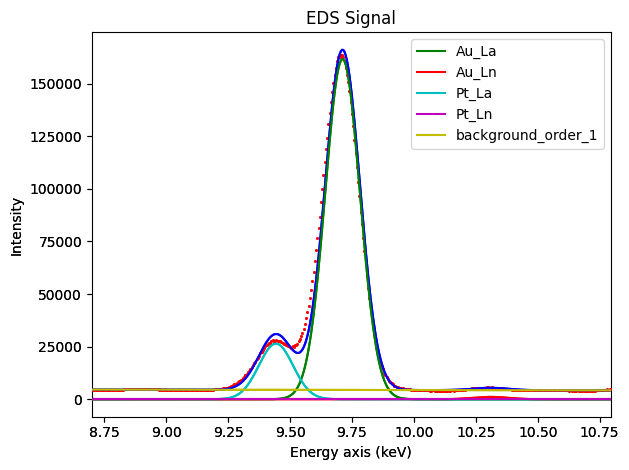

[########################################] | 100% Completed | 104.44 ms
From Ma lines (local fitting):
Au: 86.2%
Pt: 13.8%


In [20]:
l_model = l_spectrum.create_model(auto_background=False)
l_model.add_polynomial_background(order=1)
l_model.fit_background()
l_model.multifit()

# We can also further refine particular peaks which are of interest to us
l_refine_elements = {"Au", "Pt"}
l_cal_lines = [line for line in l_spectrum.metadata.Sample.xray_lines
               for e in l_refine_elements if e+"_" in line]
l_model.calibrate_xray_lines(calibrate="energy", xray_lines=l_cal_lines, kind="multi")
l_model.calibrate_xray_lines(calibrate="sub_weight", xray_lines=l_cal_lines, kind="multi")
l_model.calibrate_xray_lines(calibrate="width", xray_lines=l_cal_lines, kind="multi")

# spectrum_model.print_current_values()  # Uncomment to see all fitting parameters (there are a lot)
l_model.plot(plot_components=True)
names = [comp.name for comp in l_model.active_components]
colors = [line.get_color() for line in plt.gca().get_lines()[-len(names):]]
handles = [Line2D([0], [0], color=c, label=n) for n, c in zip(names, colors)]
plt.gca().legend(handles=handles, loc="best")
plt.show()

l_intensities = l_model.get_lines_intensity(xray_lines=["Au_La", "Pt_La"])
# Following line references the k factors set previously
L_quant_local = l_spectrum.quantification(l_intensities, method='CL', factors=k_factors_La)
print("From Ma lines (local fitting):\n"
      f"Au: {L_quant_local[0].data[0]/100:.1%}\n"
      f"Pt: {L_quant_local[1].data[0]/100:.1%}\n")

We can see that we get slightly different results by doing this quantification locally rather than globally. For the more crowded energy range around the M lines our quantification changed significantly, while the change was relatively minor for the energy range around the L lines. This may indicate that the quantification based on L lines is slightly more reliable. Or, at least, it is less sensitive to our choice of fitting parameters: the absolute quantification still depends on how good the $k$ factors are for each pair of lines.

## Quantifying a spectrum image

A spectrum image is a 3-or-4 dimensional dataset with: 2 spatial dimension (x & y), one energy dimension, and (usually) a time dimension arising from its collection as a series of consencutive scans. We can load this data with the keyword arguments `sum_frames=False` and `load_SI_image_stack=True`.

For most real datasets it is infeasible to load the full dataset this way with the default settings of `hyperspy`: its size will exceed the amount of RAM in the workstation.

If we want to load the full dataset anyway, we can take advantage of the fact that the 4D datacube is very _sparse_, which is to say that most of the values will be zero. Further, where the values are greater than zero they are usually small intergers (less than, say, about 10) representing counts per pixel per energy channel per scan frame). By using the keyword parameter `SI_dtype` we can change the datatype used for the internal representation of the data to something very small and efficient. We'll use the datatype `uint8` for this purpose, which can represent unsigned (positive) integers up to $2^8-1=255$.

This on its own is not quite good enough to load the full dataset into RAM, so we'll also use the keyword parameter `rebin_energy` to coarsen the energy binning. How much we can reasonably do this depends on the energy resolution of the system as compared with the dispersion of the detector. For the file I'm using as an example, we can get away with a rebinning factor of 8, which will scale down the energy dimension from 4096 channels to 512 channels. With the settings used during the collection of the dataset the original dispersion was 5 eV, so after rebinning the new effective dispersion is 40 eV. This is still less than half of the reported energy resolution at Mn K$\alpha$ of 130 eV (in `metadata.Acquisition_instrument.TEM.Detector.EDS.energy_resolution_MnKa`).

Both of these steps combined allow us to load the full dataset:

In [43]:
fname: str | Path | None = None  # Set filename, or set to None for interactive file selection
rebin_size: int = 8

if fname is not None:
    infile = hs.load(fname,
                     load_SI_image_stack=True,
                     sum_frames=False,
                     lazy=False,
                     rebin_energy=rebin_size,
                     SI_dtype="uint8")
else:
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    root = Tk()
    root.iconify()
    root.attributes('-topmost', True)
    root.update()
    try:
        infile = hs.load(askopenfilename(parent=root),
                         load_SI_image_stack=True,
                         sum_frames=False,
                         lazy=False,
                         rebin_energy=rebin_size,
                         SI_dtype="uint8")
    finally:
        root.attributes('-topmost', False)
        root.destroy()

In [44]:
dataset_alldims = infile[-1]
print(f"{dataset_alldims.axes_manager['x']} size: {dataset_alldims.axes_manager['x'].size} px\n"
      f"{dataset_alldims.axes_manager['y']} size: {dataset_alldims.axes_manager['y'].size} px\n"
      f"{dataset_alldims.axes_manager['Time']} size: {dataset_alldims.axes_manager['Time'].size} frames\n"
      f"{dataset_alldims.axes_manager['X-ray energy']} size: {dataset_alldims.axes_manager['X-ray energy'].size} channels\n")

x axis size: 512 px
y axis size: 512 px
Time axis size: 360 frames
X-ray energy axis size: 512 channels


There's some interesting things we can try to do with this full dataset a bit later, but for now let's clear them out of memory and work with the much more compact spectrum images pre-computed by Velox. The form of the dataset when loaded this way depends on how it was saved from Velox, specifically which elements were selected for mapping and how that map was being displayed (e.g. "Net" vs. "At%"). For this example I'll be loading a pair of spectrum images saved in the form "Net":

In [45]:
del infile
del dataset_alldims

if fname is not None:
    infile = hs.load(fname, lazy=False)
else:
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    root = Tk()
    root.iconify()
    root.attributes('-topmost', True)
    root.update()
    try:
        infile = hs.load(askopenfilename(parent=root), lazy=False)
    finally:
        root.attributes('-topmost', False)
        root.destroy()

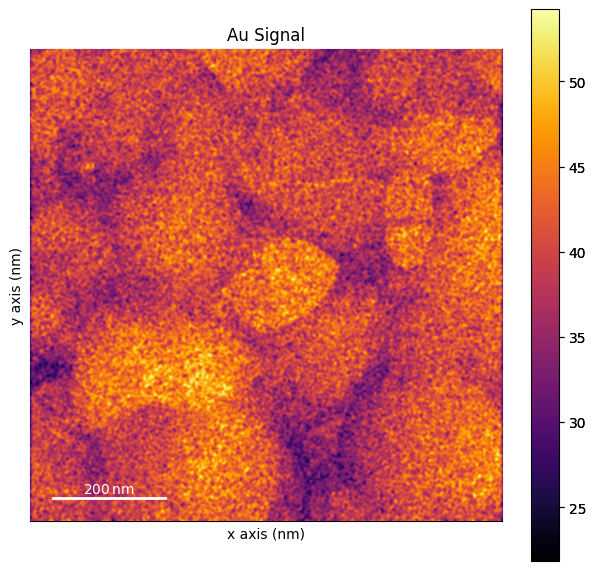

In [56]:
# I just found these indices by manual inspection of my input file
simage_a = infile[4]
simage_b = infile[6]

simage_a.plot(cmap="inferno")

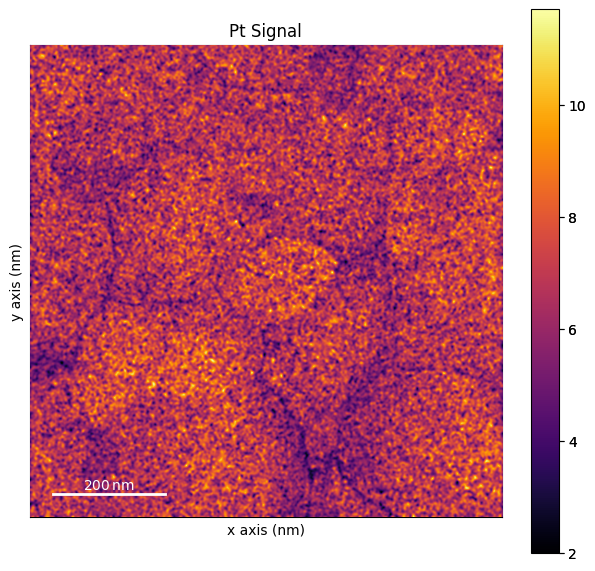

In [57]:
simage_b.plot(cmap="inferno")

There are some differences in intensity at some of the grain boundaries in these two datasets that we might want to explore more thoroughly.

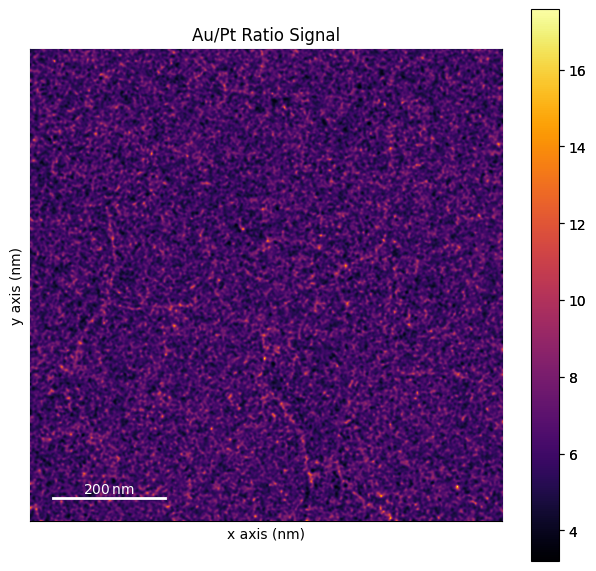

In [63]:
ratio = simage_a/simage_b
ratio.metadata.General.title = "Au/Pt Ratio"  # Update the title for less confusing display
ratio.plot(cmap="inferno")